# **Project 6: Customer Segmentation**
**Completed By:** Chinyere Okpara  
**Submission Date:** February 11, 2023
  
  
**Project Objective**:  
AllLife Bank wants to focus on its credit card customer base in the next financial year. They've been advised by their marketing research team, that the penetration in the market can be improved. 

Based on this input, the marketing team proposes to run personalized campaigns to target new customers as well as upsell existing customers. They also hope to gain insight into customers who reported poor service support.

Additionally, the operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster.

The objective of this analysis is to identify different segments of the existing customers, based on their spending patterns as well as past interaction with the bank. Using clustering algorithms, provide recommendations to the bank on how to better market to and service these customers.

**Variable List:**  
* **Sl_No:**  Primary key of the records
* **Customer Key:**  Customer identification number
* **Average Credit Limit:**  Average credit limit of each customer for all credit cards
* **Total Credit Cards:**  Total number of credit cards possessed by the customer
* **Total Bank Visits:**  Total number of visits that customer made (yearly) personally to the bank
* **Total Online Visits:**  Total number of visits or online logins made by the customer (yearly)
* **Total Calls made:**  Total number of calls made by the customer to the bank or its customer service department (yearly)


# **I. Project Set-Up**
Importing necessary libraries, dataset, and verifying error-free data upload. Missing values, duplicate observations, and data type are also assessed.
And user-defined functions are also defined.

In [2]:
#Data wrangling 
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Command to tell Python to actually display the graphs
%matplotlib inline

# Igonre warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Access data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Define Functions**

### Exploratory Data Analysis and Summary

In [4]:
#View N top levels counts and proportions for discrete/categorical variables 
#Categorical Summary
def categorical_summary(data, num_to_display):
  for colname in data.dtypes[(data.dtypes == 'object')|(data.dtypes == 'category')].index:
      val_counts = data[colname].value_counts(dropna=False)  # i want to see NA counts
      val_prop = data[colname].value_counts(dropna=False, normalize=True) 
      df1_n = val_counts[:num_to_display]
      df2_p = val_prop[:num_to_display]
      print(colname)
      print(pd.DataFrame({"Count":df1_n,"Proportion (%)":df2_p*100}))
      print("------")
      #print(val_counts[:num_to_display])
      #print(])
      if len(val_counts) > num_to_display:
          print(f'Only displaying first {num_to_display} of {len(val_counts)} values.')
      print('\n\n')

In [5]:
#Graph boxplot and histogram on same plot
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## **Data Import**

In [6]:
#Load Data, setting Index Column = Sl_No
df = pd.read_csv('/content/drive/MyDrive/GitHub Projects/Data/Credit_Card_Customer_Data.csv', index_col=0);

In [101]:
#Remove duplicates (if any)
df.drop_duplicates(inplace = True)
print(f'There are {df.shape[0]} observations with {df.shape[1]} variables.') 

There are 660 observations with 6 variables.


In [102]:
#Sanity check to verify data correctly imported
#View random 10 rows 
np.random.seed(101)
df.sample(n=10)

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
642,27212,144000,10,0,10,2
476,65781,45000,5,5,2,2
564,96269,69000,5,4,1,0
428,64519,50000,7,5,2,2
37,46388,9000,3,1,4,10
608,90191,34000,6,3,1,0
329,26678,14000,4,4,2,1
465,36504,52000,4,2,1,2
57,32828,6000,1,0,2,5


In [103]:
# Data Strucuture Review (Overall):
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer_Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 36.1 KB


In [104]:
#Data Strucuture Review (Overall):
df.describe()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.00,660.00,660.00,660.00,660.00,660.00
mean,55141.44,34574.24,4.71,2.40,2.61,3.58
std,25627.77,37625.49,2.17,1.63,2.94,2.87
min,11265.00,3000.00,1.00,0.00,0.00,0.00
25%,33825.25,10000.00,3.00,1.00,1.00,1.00
50%,53874.50,18000.00,5.00,2.00,2.00,3.00
75%,77202.50,48000.00,6.00,4.00,4.00,5.00
max,99843.00,200000.00,10.00,5.00,15.00,10.00


In [105]:
#Customer Key is technically a string variable used to label. 
#Let's convert Customer Key to sting and view summary analysis.
df['Customer_Key'] = df['Customer_Key'].astype(str)
categorical_summary(df, 10)

Customer_Key
       Count  Proportion (%)
97935      2            0.30
50706      2            0.30
47437      2            0.30
37252      2            0.30
96929      2            0.30
60851      1            0.15
58019      1            0.15
87219      1            0.15
36839      1            0.15
12663      1            0.15
------
Only displaying first 10 of 655 values.





In [106]:
#Viewing customers who appear multiple times in dataset. 
customer_count = df['Customer_Key'].value_counts(dropna=False).rename_axis('Customer_Key').reset_index(name='counts')
duplicate_customers = customer_count[customer_count.counts>1].Customer_Key
df[df['Customer_Key'].isin(duplicate_customers)].sort_values(by=['Customer_Key'])

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
49,37252,6000,4,0,2,8
433,37252,59000,6,2,1,2
5,47437,100000,6,0,12,3
333,47437,17000,7,3,1,0
412,50706,44000,4,5,0,2
542,50706,60000,7,5,2,2
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2
105,97935,17000,2,1,2,10


***Notes:***
*   Data set contains 660 observations and five numeric independent variables. 
*   Data does not contain missing variables; however, five customers appear twice in the dataset. 
  *  Under ordinary circumstances, the most recent record will only be included in the dataset. Unfortunately, there is no way to determine the most recent record so all observations will be used to identify overarching trends. 
*   The average credit limit is both skewed and of a greater magnitude than the other customer. Log10 transformation will be applied to better observe patterns.

# **II. Exploratory Data Analysis**

## **Univariate Analysis**

### **Observation on Average Credit Limit**

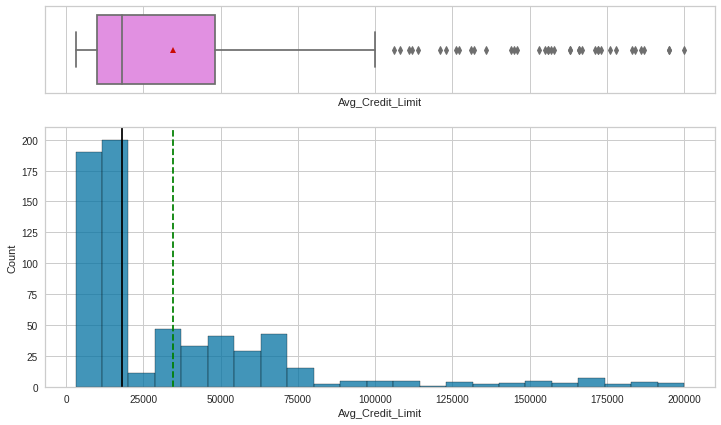

In [77]:
histogram_boxplot(df, "Avg_Credit_Limit")

* Average credit limit ranges from \$3,000 to \$200,000 
* It has a right-skew distribution with half of the customer population falling on either side of $18,000
* Average credit limits exceeding \$100,000 are considered outliers 

### **Observation on Total Credit Cards**

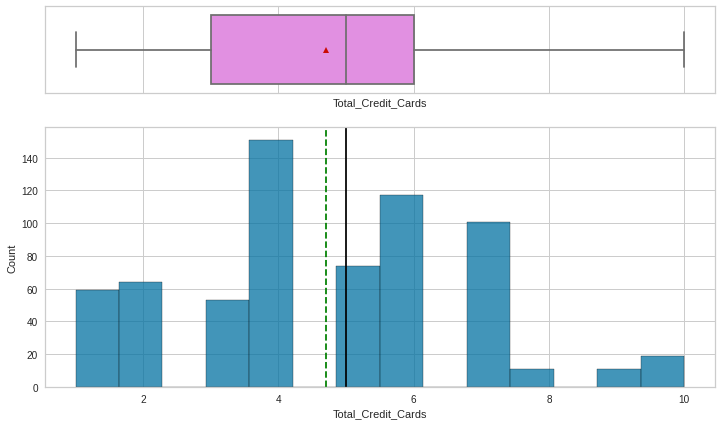

In [78]:
histogram_boxplot(df, "Total_Credit_Cards")

* The total number of credit cards ranges between 1 and 10 per customer with a rounded average and median of 5 cards


### **Observation on Total Bank Visits**

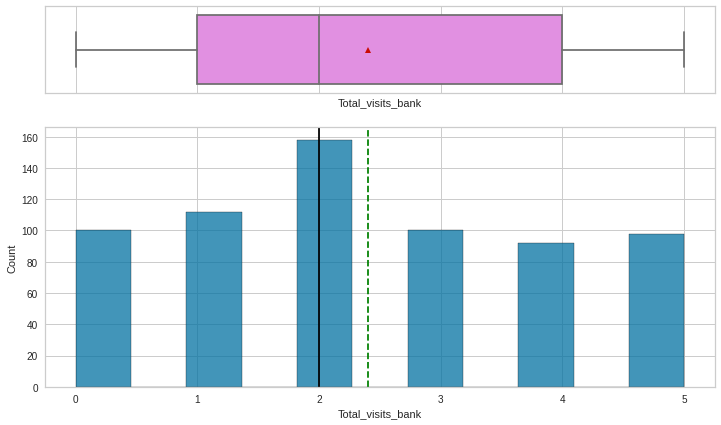

In [79]:
histogram_boxplot(df, "Total_visits_bank")

* The number of physical visits range between 0 to 5 visits per customer with a rounded average and median of 2 visits 

### **Observation on Total Online Visits**

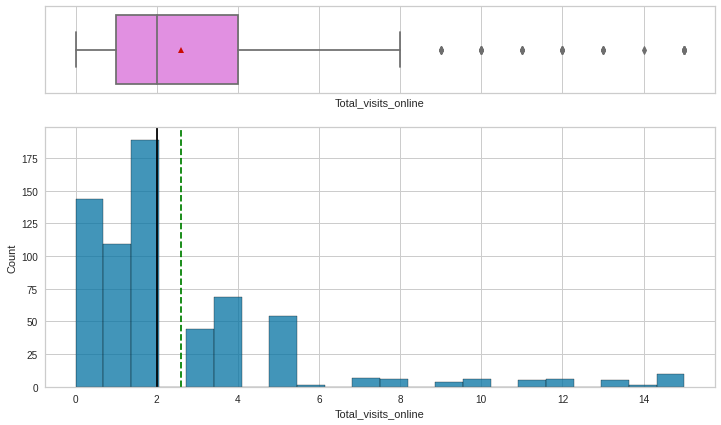

In [80]:
histogram_boxplot(df, "Total_visits_online")

* The number of online with has a right skew distribution. Values range between 0 and 14 but the median value = 2

* Here, online visits greater than 8 are considered outliers

### **Observation on Total Calls Made**

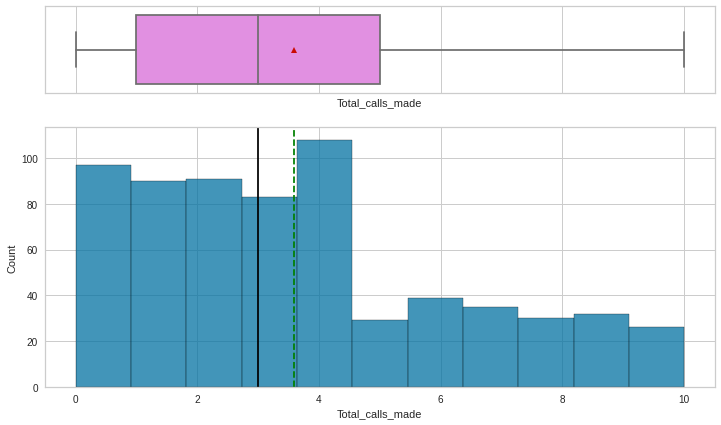

In [81]:
histogram_boxplot(df, "Total_calls_made")

* Total number of calls made range from 0 to 10 with median = 3. 
* Partitioning at 5, the total number of calls made seem uniformaly distributed where calls \[0-5\] are observed more frequently than \(5,10\].

## **Muiltivariate Analysis**

In [7]:
#Appliying log10 to cvareage credit limit and saving results as a new variables
df['log10_Avg_Credit_Limit'] = np.log10(df['Avg_Credit_Limit']+1)

### **Correlation Matrix**

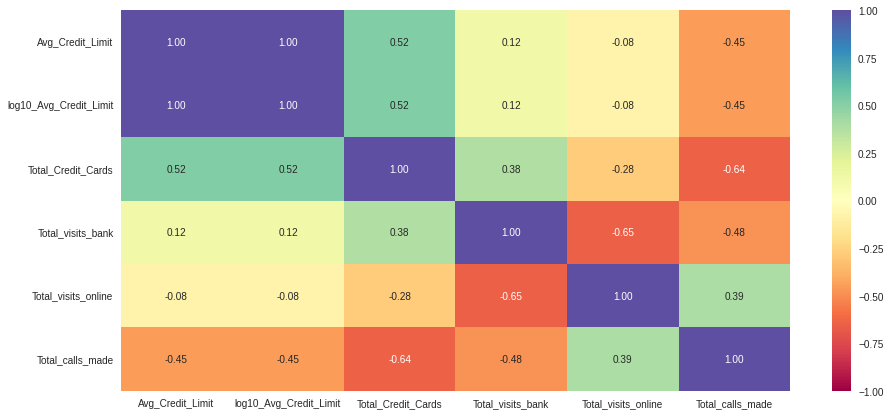

In [83]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[['Avg_Credit_Limit', 'log10_Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']].corr(method = 'spearman'), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

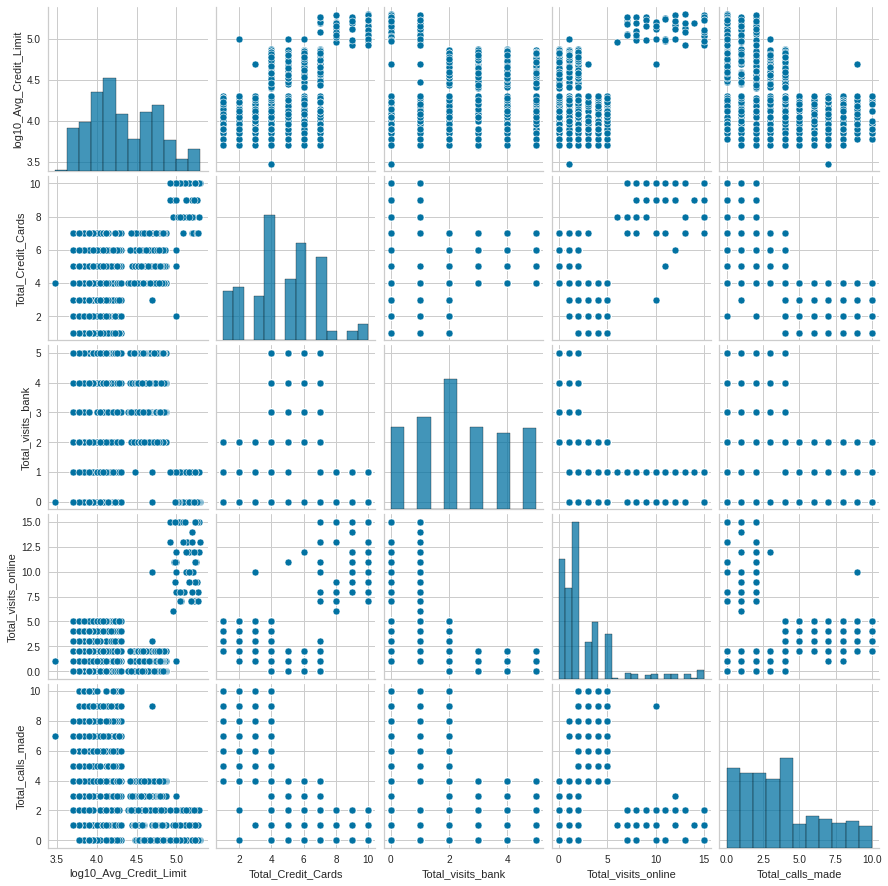

In [84]:
sns.pairplot(data=df, vars=['log10_Avg_Credit_Limit', 'Total_Credit_Cards','Total_visits_bank', 'Total_visits_online', 'Total_calls_made']);

* Spearman's rank correlation (rho) (as opposed to Pearson) was utilized as measure is not sensitve to outliers as we have in both credit limit and total online visits.  

**Postive Correlation [for rho <= 0.4]** 
* As the number of total credit cards increases, the average spending also tends to increase (rho = 0.52)

**Negative Correlation [for rho >= -0.4]** 
* As the number of total calls made increases, there is a (1) moderate negative correction in the average spending limit (rho = - 0.45) and total bank visits (rho = -0.48) and a (2) stong negative in total credit cards (rho = -0.64). 

# **III. Clustering: Customer Segmentation**

## **Data Pre-Processing**

### **Feature Scaling**

In [8]:
# Subseting the data
subset_df = df.drop(['Customer_Key', 'Avg_Credit_Limit'], axis=1)

#Appliying standardScaler standardizes (subtracting the mean and then scaling to unit variance)
sc = StandardScaler()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(subset_df),
    columns = subset_df.columns,
    )
subset_scaled_df.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,log10_Avg_Credit_Limit
0,-1.25,-0.86,-0.55,-1.25,1.63
1,-0.79,-1.47,2.52,1.89,0.89
2,1.06,-0.86,0.13,0.15,0.89
3,0.14,-0.86,-0.55,0.15,0.34
4,0.60,-1.47,3.20,-0.20,1.63


## **K-means Clustering**

### **Determining K: Elbow Plot**

In [86]:
#Kmeans clutsering, identifying correct number of clusters (1-9)
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_scaled_df)  # Fit kMeans on the data
    prediction = model.predict(subset_scaled_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_scaled_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

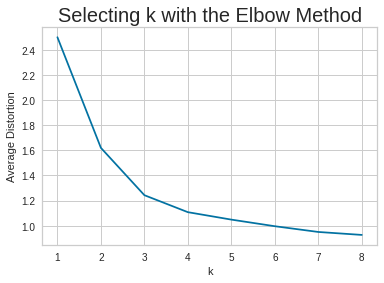

In [87]:
#Elbow Plot
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

K is not clearly distinguished in the elbow plot; 3 or 4 clusters seem like possible groupings.

### **Determining K: Silhouette Score**

For n_clusters = 2, silhouette score is 0.5205008857316231
For n_clusters = 3, silhouette score is 0.6054879941056434
For n_clusters = 4, silhouette score is 0.43304953035438565
For n_clusters = 5, silhouette score is 0.4000467616759147
For n_clusters = 6, silhouette score is 0.26773381783973843
For n_clusters = 7, silhouette score is 0.27141350734894387
For n_clusters = 8, silhouette score is 0.2471767214947603


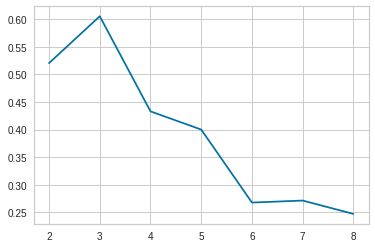

In [88]:
#Silhouette score
sil_score = []  # Create empty list
cluster_list = list(range(2, 9))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_scaled_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

K = 3 has the highest sillouhette score; hence, data should be clustered into three partitions. 

In [9]:
#Save k-means cluster (K=3) to orginal dataset
best_k_kmeans_mod = KMeans(3)
best_k_kmeans_mod.fit(subset_scaled_df)
prediction = best_k_kmeans_mod.predict(subset_scaled_df)

#Append the prediction 
df["clst_KM"] = prediction

print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,log10_Avg_Credit_Limit,clst_KM
Sl_No,,,,,,,,
1,87073,100000,2,1,1,0,5.00,2
2,38414,50000,3,0,10,9,4.70,0
3,17341,50000,7,1,3,4,4.70,2
4,40496,30000,5,1,1,4,4.48,2
5,47437,100000,6,0,12,3,5.00,1


## **Hierarchical Clustering**

In [90]:
#Identifying metric and linkage using cophenetic correlation
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))

        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9421908394744032, which is obtained with Euclidean distance and average linkage.


In [92]:
#Since euclidean distance is chosen to be the best performing metric, additional 
## linkage method, only atributable to euclidean, will be analyse to find 
## additional higher cophenetic correlations  (if any).

#subset_scaled_df

# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm



Cophenetic correlation for single linkage is 0.9316813396699605.
Cophenetic correlation for complete linkage is 0.9328555368298153.
Cophenetic correlation for average linkage is 0.9421908394744032.
Cophenetic correlation for centroid linkage is 0.939698658790079.
Cophenetic correlation for ward linkage is 0.8678786846283268.
Cophenetic correlation for weighted linkage is 0.9361653426556381.


In [93]:
print("Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
))

Highest cophenetic correlation is 0.9421908394744032, which is obtained with average linkage.


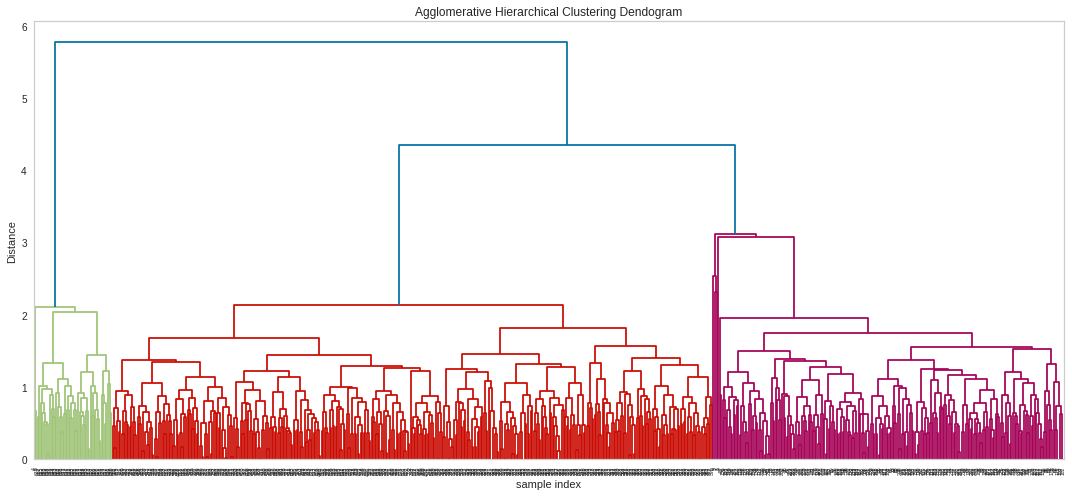

In [98]:
Z = linkage(subset_scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(subset_scaled_df))

plt.figure(figsize=(15, 7))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dend = dendrogram(Z)
plt.axhline(y=7.3, c="red", lw=1, linestyle="dashdot")
plt.grid(False)
plt.tight_layout();

With hierarchical clustering, measured with Euclidean distance and average linkage has highest cophentic correlation = 0.94. With those parameters, the optimal number of clusters = 3.

In [10]:
#Save hierarchical cluster results to orginal dataset (n = 2)
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

#Append the prediction 
df["clst_H"] = HCmodel.labels_

print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,log10_Avg_Credit_Limit,clst_KM,clst_H
Sl_No,,,,,,,,,
1,87073,100000,2,1,1,0,5.00,2,2
2,38414,50000,3,0,10,9,4.70,0,0
3,17341,50000,7,1,3,4,4.70,2,2
4,40496,30000,5,1,1,4,4.48,2,2
5,47437,100000,6,0,12,3,5.00,1,1


# **IV. Cluster Profiling**

## **Clustering Comparisons**

### **K-Means Clusters**

In [111]:
km_cluster = df.groupby("clst_KM").mean()
km_cluster["Customer_Count"] = (df.groupby("clst_KM")["Customer_Key"].count().values)
km_cluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,log10_Avg_Credit_Limit,clst_H,Customer_Count
clst_KM,,,,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805,4.410697,2.000000,385
1,12151.111111,2.422222,0.937778,3.546667,6.857778,4.045967,0.044444,225
2,141040.000000,8.740000,0.600000,10.900000,1.080000,5.135758,1.000000,50


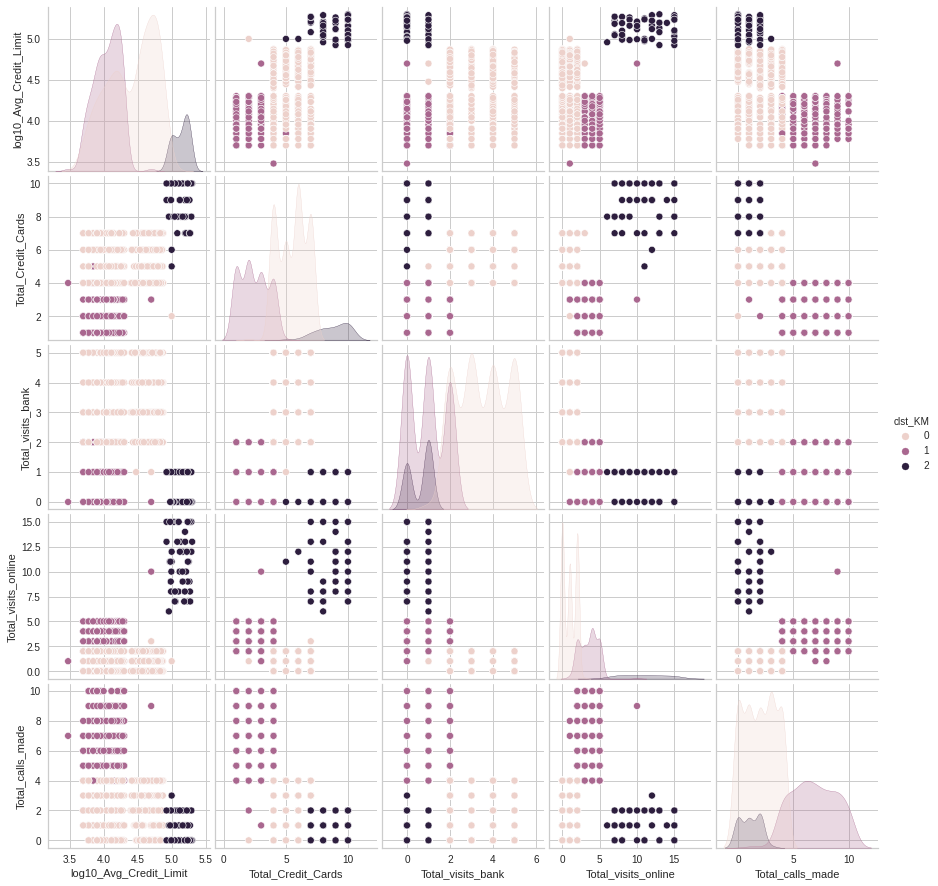

In [112]:
sns.pairplot(data=df, vars=['log10_Avg_Credit_Limit', 'Total_Credit_Cards','Total_visits_bank', 'Total_visits_online', 'Total_calls_made'], hue='clst_KM');

* Cluster 1 represented the largest partition (N = 385, 58.33%) and represents the population with a higher number of total bank visits and a lower number of online visits and calls made. The average number of credit cards falls between 4-7. And spending is not extreme. 

* Cluster 0 represented the second largest partition (N = 225, 34.09%). Customers in this group have the lowest average credit limit, the lowest number of cards, and the lowest total bank and online visits compared to the other two groups. However, they have the highest number of calls made.


* Cluster 2 represented the smallest partition (N = 50, 7.58%). Customers in this group have very high average credit limits, number of cards, and online actvity. They also tend to have a very low number of bank visits and total calls made. 


### **Hierarchical Clusters**

In [11]:
tab = df.groupby(['clst_KM', 'clst_H']).size()
tab_df = pd.DataFrame(tab, columns = ['Count'])
tab_df['Proportion (%)'] = (tab/sum(tab))*100

tab_df

Count  Proportion (%)
clst_KM clst_H                       
0       0         220           33.33
        2           5            0.76
1       1          50            7.58
2       2         385           58.33

* K-means and heirarchical clustering produce nearly identical groups with the exception of 5 hierarchical level 2 observations being group im level 0 K-means cluster

In [113]:
h_cluster = df.groupby("clst_H").mean()
h_cluster["Customer_Count"] = (df.groupby("clst_H")["Customer_Key"].count().values)
h_cluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,log10_Avg_Credit_Limit,clst_KM,Customer_Count
clst_H,,,,,,,,
0,12240.909091,2.386364,0.931818,3.586364,6.931818,4.049691,1.000000,220
1,141040.000000,8.740000,0.600000,10.900000,1.080000,5.135758,2.000000,50
2,33523.076923,5.497436,3.464103,0.989744,2.015385,4.403921,0.012821,390


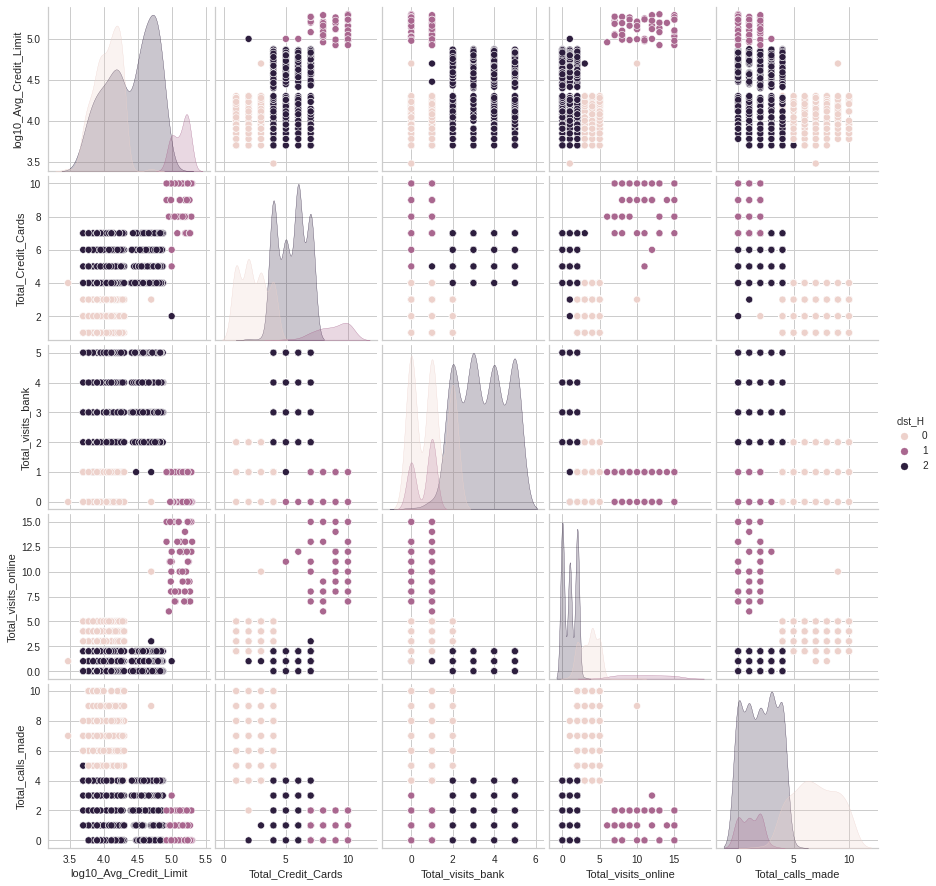

In [115]:
sns.pairplot(data=df, vars=['log10_Avg_Credit_Limit', 'Total_Credit_Cards','Total_visits_bank', 'Total_visits_online', 'Total_calls_made'], hue='clst_H');

*   Because hierarchical cluster produced almost identical groupning as K-Means, similar trends can be observed between clusters. 



# **V. Executive Summary**

* Six hundred and sixty customers were included in the customer segmentation analysis. For each customer, five banking characteristics were observed:  average credit limit, total credit cards, total bank visits, total online visits, and total calls made to the bank or customer service


* The total number of credit cards ranges between 1 and 10 per customer with a rounded average and median of 5 cards. In this population, as the number of total credit cards increases, the average spending also tends to increase (rho = 0.52).

* As the number of total calls made increases, there is a (1) moderate negative correction in the average spending limit (rho = - 0.45) and total bank visits (rho = -0.48) and a (2) strong negative in total credit cards (rho = -0.64). The decrease in total bank visits may indicate customers are either addressing concerns via call or in the bank, but not both. While the decrease in total credit cards may indicate a dissatisfaction with service. 

* Because k-means segments the population into more distinct groups, a partitioning of 3 will be used to segment the population.


* Cluster 1 represented the largest partition (N = 385, 58.33%) and represent the population with a higher number of total bank visits and a lower number of online visits and calls made. The average number of credit cards falls between 4-7. And spending is not extreme. This may represent traditional bankers and/or satisfying customers (since they tend to own multiple cards) who do not interact with customer service often.

* Cluster 0 represented the second largest partition (N = 225, 34.09%). They have the lowest average credit limit, the lowest number of cards, and the lowest total bank and online visits compared to the other two groups. However, they have the highest number of calls made. This may represent an unsatisfied customer segmentation. 

* Cluster 2 represented the smallest partition (N = 50, 7.58%). Customers in this group have very high average credit limits and number of cards. They also tend to have a very low number of bank visits and total calls made. Online activity is not differentiable in this group. This group may represent a high-spend population.

* The operations team should consider an online base service delivery model as customers with the highest online activity had the highest number of credit cards and average spend limit. The call delivery model seems to be least effective as customers who had more calls had the lowest average credit limits and cards.

* With an implementation of a new service delivery model, the marketing should target customers in cluster 0 as they have the lowest number of cards. And customers in cluster 1 should be upselled as they already have multiple cards; however, have very low online activity. The introduction of an online service delivery method might generate new sales
